In [69]:
import torch
import cv2
from torchvision import transforms
import time
import matplotlib.pyplot as plt
from src.models.posenet import PoseNet 

model = PoseNet((5, 6 + 1), 3, 'resnet18', True)
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')

# with torch.no_grad():
#     self.model.load_state_dict(torch.load(checkpoint_path))
#     self.model.to(self.device)
#     self.model.eval()
with torch.no_grad():
    model.load_state_dict(torch.load('weights/checkpoint.pth'))
    model.to(device)
    model.eval()


convert_tensor = transforms.ToTensor()
start_time = time.time()

image = cv2.imread('dataset/hrp/images/0001.jpg', cv2.IMREAD_COLOR)
orig_frame = image.copy()

image = convert_tensor(image)
# add dimension
image = image[None, :, :, :]
image.size()
image = image.to(device)
print("--- %s seconds ---" % (time.time() - start_time))

outputs = model(image)
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.004957914352416992 seconds ---
--- 0.330214262008667 seconds ---


In [67]:
image.shape

torch.Size([1, 3, 480, 640])

In [51]:
# image.shape
torch.onnx.export(model, image, "model/nimbro.onnx")

/usr/local/lib/python3.10/dist-packages/torch/onnx/_internal/jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:687: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at ../torch/csrc/jit/passes/onnx/shape_type_inference.cpp:1884.)
  _C._jit_pass_onnx_graph_shape_type_inference(
/usr/local/lib/python3.10/dist-packages/torch/onnx/utils.py:1178: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the export

In [27]:
# Construct the command for Model Optimizer.
# onnx_path= 'keypoint_rcnn.onnx'
# mo_command = f"""mo
#                  --input_model "{onnx_path}"
#                  --compress_to_fp16
#                  --output_dir "{'model'}"
#                  """
# mo_command = " ".join(mo_command.split())
# print("Model Optimizer command to convert the ONNX model to OpenVINO:")

# mo_result = %sx $mo_command
# print("\n".join(mo_result))

# RUN IN TERMINAL
# ===================================
# mo --input_model 'keypoint_rcnn.onnx' --compress_to_fp16 --output_dir 'model'
# ===================================

Model Optimizer command to convert the ONNX model to OpenVINO:
/bin/bash: line 1: mo: command not found


In [52]:
keypoints_classes_ids2names = {0: 'Head', 1: 'Trunk', 2: 'RH', 3: 'LH', 4: 'RF', 5: 'LF'}

def visualize(image, bboxes=None, keypoints=None, image_original=None, bboxes_original=None, keypoints_original=None):
    fontsize = 18
    
    if bboxes is not None:
        for bbox in bboxes:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        print(kps)
        for idx, kp in enumerate(kps):
            kp = [int(kp[0]), int(kp[1])]
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), -1)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(40,40))
        plt.imshow(image)

    else:
        if bboxes is not None:
            for bbox in bboxes_original:
                start_point = (bbox[0], bbox[1])
                end_point = (bbox[2], bbox[3])
                image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)
        
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), -1)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 1, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 20))

        ax[0].imshow(image_original)
        ax[0].set_title('Original image', fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)

## 1. ONNX Model in OpenVINO Runtime

In [60]:
from openvino.runtime import Core
# Load the network to OpenVINO Runtime.
ie = Core()
model_onnx = ie.read_model(model='model/nimbro.onnx')
compiled_model_onnx = ie.compile_model(model=model_onnx, device_name="CPU")

output_layer_onnx = compiled_model_onnx.output(0)

In [61]:
# Run inference on the input image.
start_time = time.time()
res_onnx = compiled_model_onnx([image])
print("--- %s seconds ---" % (time.time() - start_time))
# res_onnx

--- 0.0953071117401123 seconds ---


## 2. OpenVINO IR Model in OpenVINO Runtime

In [62]:
from openvino.runtime import Core
# Load the network in OpenVINO Runtime.
ie = Core()
model_ir = ie.read_model(model='model/nimbro.xml')
compiled_model_ir = ie.compile_model(model=model_ir, device_name="CPU")

# Get input and output layers.
output_layer_ir = compiled_model_ir.output(0)

In [63]:
# Run inference on the input image.
start_time = time.time()
# res_ir = compiled_model_ir([image])[output_layer_ir]
res_ir = compiled_model_ir([image])
print("--- %s seconds ---" % (time.time() - start_time))
# res_ir = [[[res_ir[0][0], res_ir[0][1]], [res_ir[0][2], res_ir[0][3]],
#           [res_ir[1][0], res_ir[1][1]], [res_ir[1][2], res_ir[1][3]],
#           [res_ir[2][0], res_ir[2][1]], [res_ir[2][2], res_ir[2][3]]]]
# res_ir

--- 0.09475231170654297 seconds ---


In [64]:
def findPeak2D(mat):
    x, y = mat.shape
    max_value = None

    for i in range(x):
        for j in range(y):
            if max_value == None or mat[i][j] > max_value: 
                max_value = mat[i][j]
                # to match with the original image, need to multiply by 4
                position = (j*4, i*4)
    return position

two = compiled_model_ir.output(2)
# res_ir[two][0][0].shape
keypoints = []
for i in range(6):
# pick 1/4 scale heatmaps
    keypoints.append(res_ir[two][0][0][i])

keypoints_coordinat = []
for i in range(6):
    result = findPeak2D(keypoints[i])
    keypoints_coordinat.append(result)
    
keypoints_result = []
for item in keypoints_coordinat:
    keypoints_result.append(list(item)) 
keypoints_result = [keypoints_result]
keypoints_result

[[[428, 188], [424, 288], [392, 300], [436, 320], [412, 392], [440, 416]]]

[[428, 188], [424, 288], [392, 300], [436, 320], [412, 392], [440, 416]]


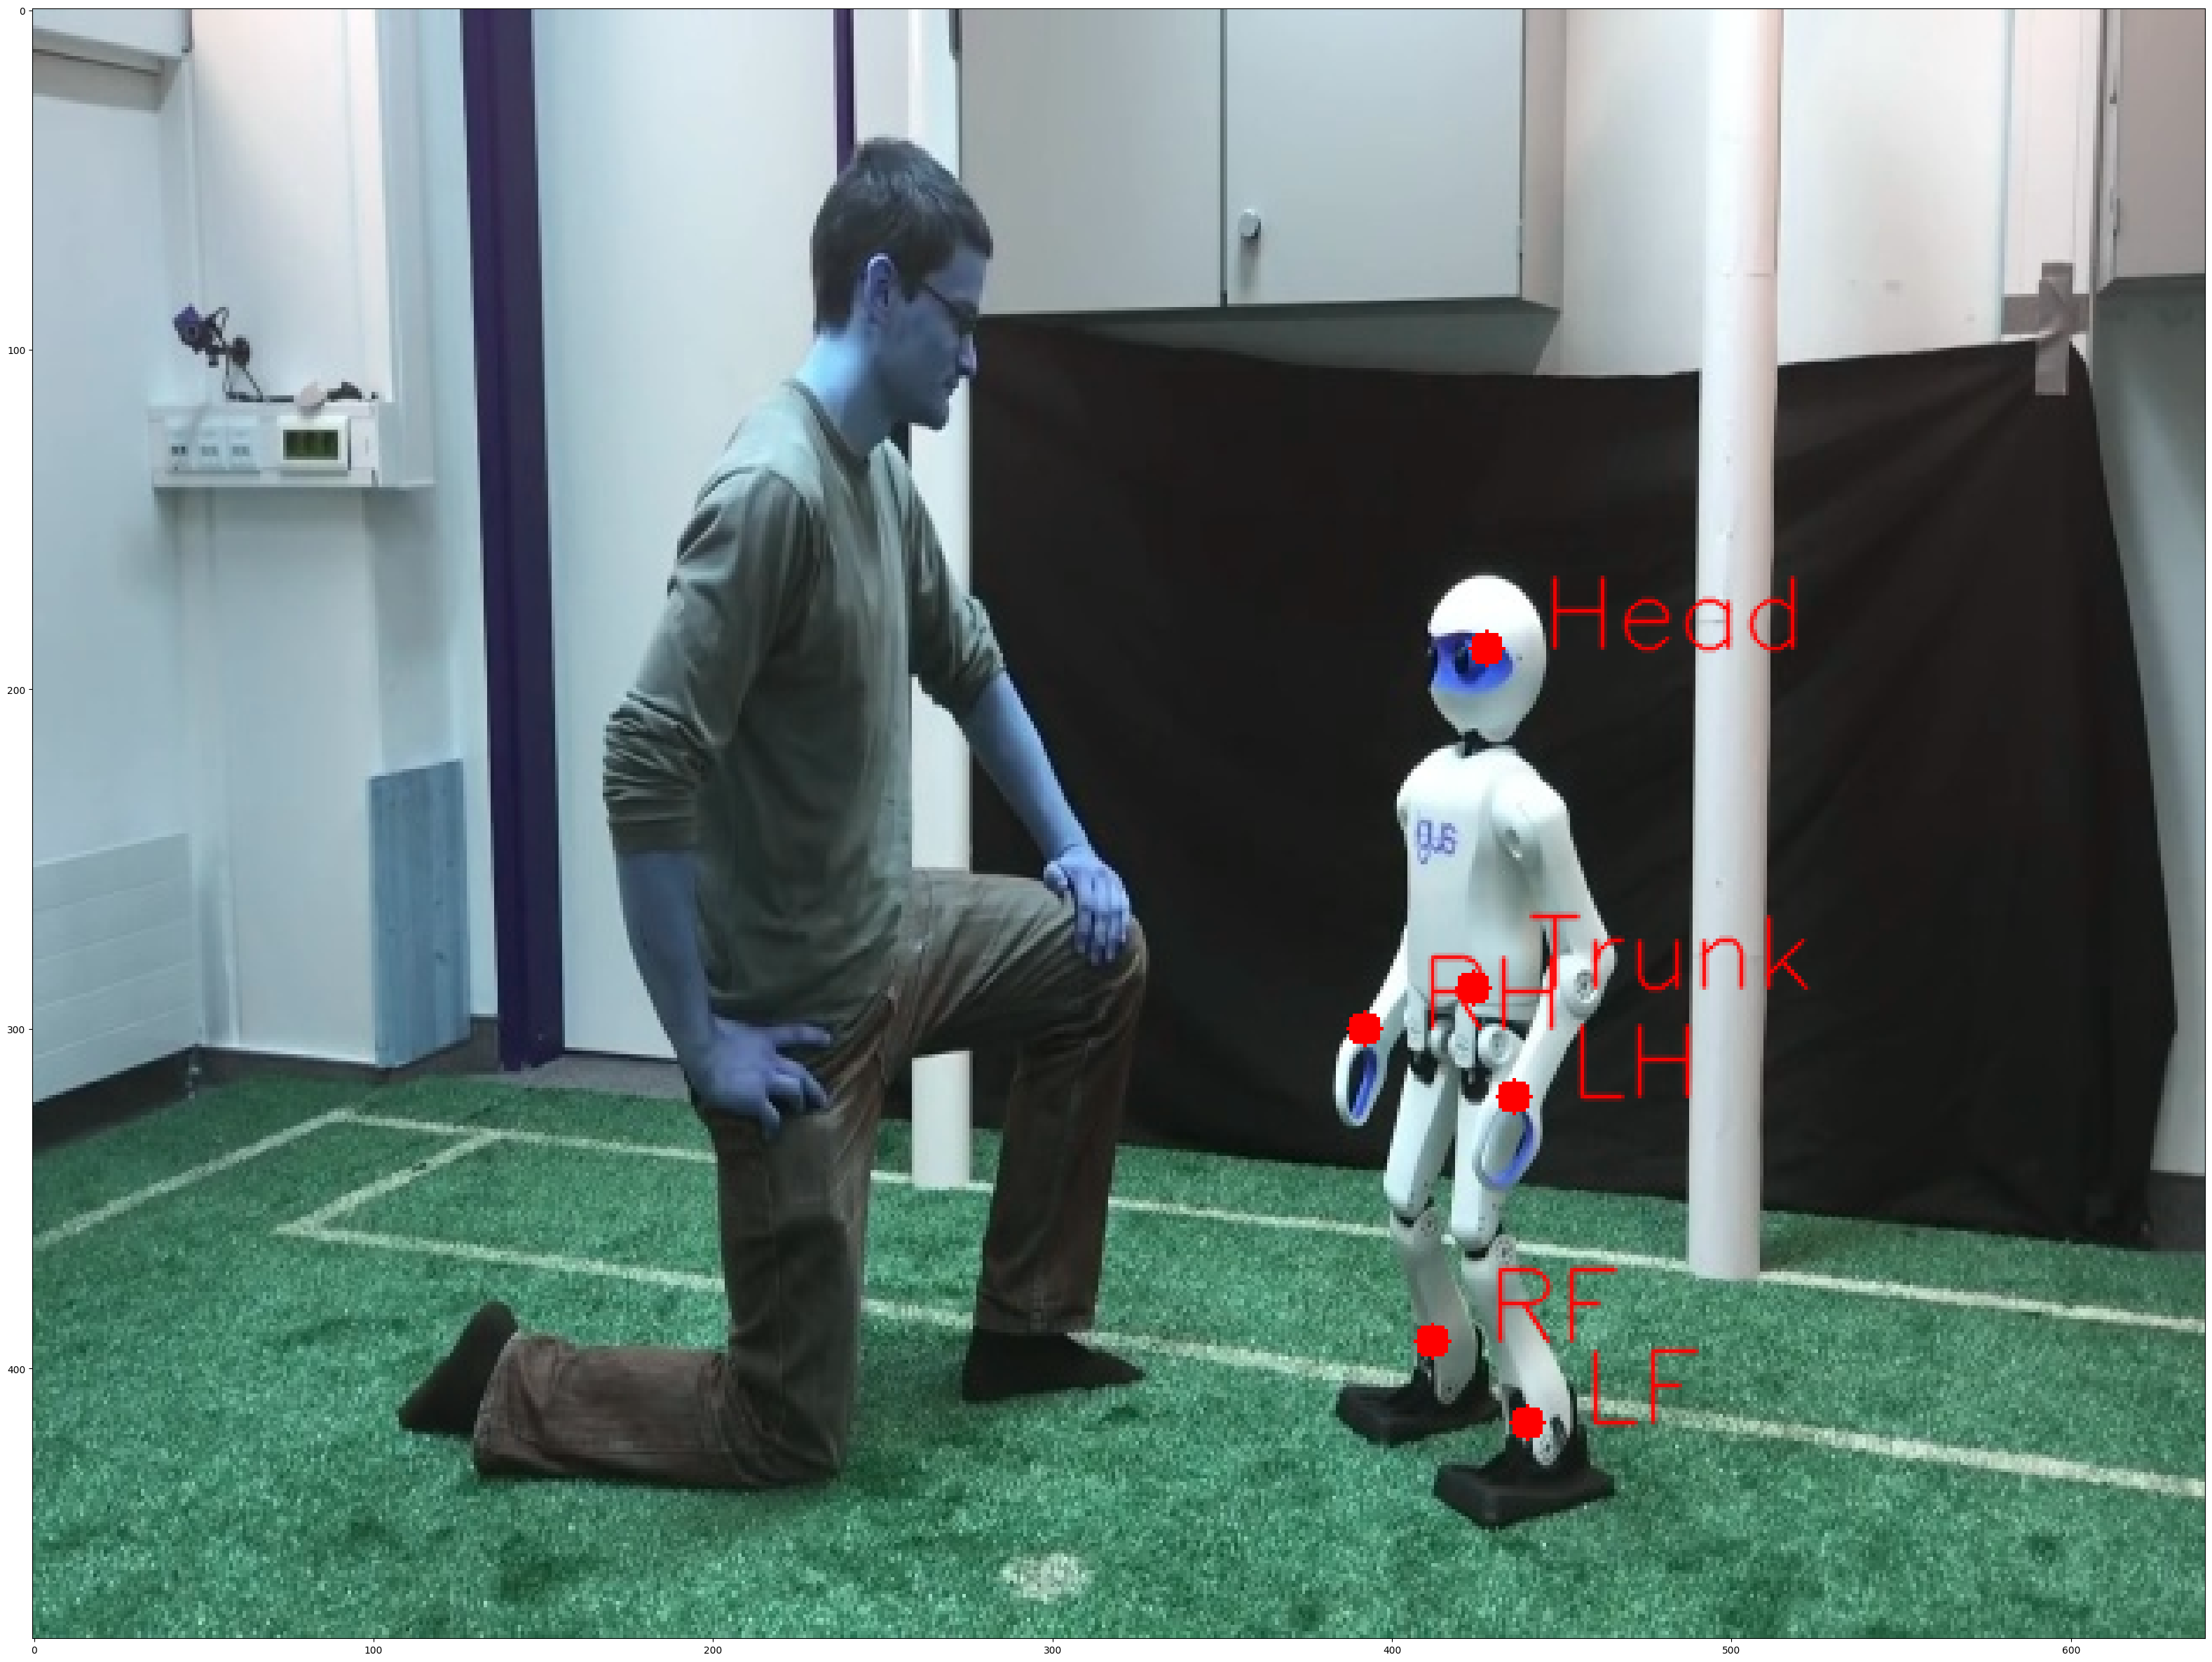

In [65]:
visualize(orig_frame, keypoints=keypoints_result)